In [3]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))
#from timeeval.utils.label_formatting import id2labels

In [18]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
from datetime import timedelta
from utils import SingleTlmyManager, get_dataset_folder #load_channel, , get_channels_file
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.ensemble import IsolationForest

BUSQUEDA_EXHAUSTIVA = False
RAWDATA             = True


mission_name = 'ESA-Mission1'
channel_name = "channel_44"


In [19]:
def get_accuracy(df_subset):
    TP      = df_subset[(df_subset["isAnomaly"]==True) & (df_subset["anomalyScore"]>0.5)].shape[0] 
    TN      = df_subset[(df_subset["isAnomaly"]==False) & (df_subset["anomalyScore"]<=0.5)].shape[0]
    FP      = df_subset[(df_subset["isAnomaly"]==False) & (df_subset["anomalyScore"]>0.5)].shape[0]
    FN      = df_subset[(df_subset["isAnomaly"]==True) & (df_subset["anomalyScore"]<=0.5)].shape[0]
    #TOTAL   = df_subset[df_subset["isAnomaly"]== True].shape[0]
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    #print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}, TOTAL: {TOTAL}, Accuracy: {accuracy:.2f}")
    return accuracy

In [20]:
#Mas de un minuto
if RAWDATA:
    tm = SingleTlmyManager(mission_name, channel_name, 
                        start_date=pd.to_datetime('2000-01-01', utc=True),
                        end_date=pd.to_datetime('2001-12-31', utc=True))
    df = tm.regularize_freq()
    tm.add_labels()
    ag = tm.get_anomaly_groups()
    start_time = ag.loc[ag.anomalyId=="id_151","start_index"].loc[0]-timedelta(minutes=60*24*15)
    end_time = ag.loc[ag.anomalyId=="id_151","end_index"].loc[0]+timedelta(minutes=60*24*1)
    df = tm.data
    df_subset = df.loc[start_time:end_time]
    
    df_subset.to_csv(f"{get_dataset_folder()}/{mission_name}/{channel_name}_subset.csv")
    print(f"Data subset saved to {get_dataset_folder()}{mission_name}/{channel_name}_iForest_subset.csv")
else:
    df_subset   = pd.read_csv(f"{get_dataset_folder()}{mission_name}/{channel_name}_iForest_subset.csv", index_col=0, parse_dates=True)
    start_time = df_subset.index.min()
    end_time = df_subset.index.max()



Data subset saved to ../../data/ESA-Mission1/channel_44_iForest_subset.csv


In [8]:
train_percent = 0.8
train_test_rec = df_subset.iloc[int(train_percent*len(df_subset))]
train_test_rec


channel_44    0.804688
isAnomaly        False
anomalyId         None
Name: 2000-02-08 11:56:46.353000+00:00, dtype: object

In [9]:
train_test_rec.name

Timestamp('2000-02-08 11:56:46.353000+0000', tz='UTC')

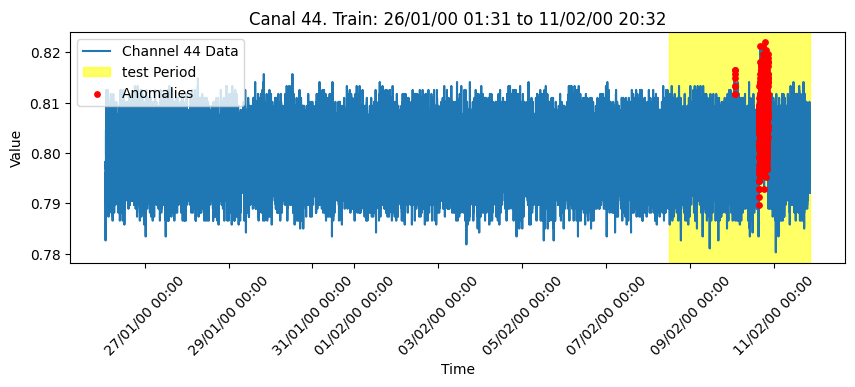

In [10]:
plt.figure(figsize=(10, 3))
plt.plot(df_subset.index, df_subset[tm.channel_name], label='Channel 44 Data')
plt.gca().axvspan(train_test_rec.name, end_time, color='yellow', alpha=0.6, label='test Period')
plt.scatter(df_subset.index[df_subset['isAnomaly']], df_subset[tm.channel_name][df_subset['isAnomaly']], 
            color='red', 
            label='Anomalies', s=15, zorder=10)

plt.title(f'Canal 44. Train: {start_time.strftime("%d/%m/%y %H:%M")} to {end_time.strftime("%d/%m/%y %H:%M")}')
plt.xlabel('Time')  
plt.ylabel('Value')
plt.xticks(rotation=45)
d_format = mdates.DateFormatter("%d/%m/%y %H:%M")  # Día-Mes-Año
# Aplicar el formato al eje x
plt.gca().xaxis.set_major_formatter(d_format)

plt.legend()    
plt.show()




Probar con un windows de 645 que es el tamaño de la anomalía.

The anomaly score of the input samples. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.

In [11]:
print(df_subset[df_subset.isAnomaly==True].shape[0], df_subset.shape[0])


653 48364


In [12]:
window_sizes = np.arange(50, 500, 50)  # Odd window sizes from 3 to 19
n_estimators = np.arange(10, 500, 50)  # Odd n_estimators from 1 to 21
g_search = product(window_sizes, n_estimators)
contamination = df_subset[df_subset.isAnomaly==True].shape[0]/df_subset.shape[0] #(df_subset["isAnomaly"]==True).mean() 
best_estimator = None
best_f1_score = 0
best_X_test = None
lst_summary = []
for window_size, n_estimators in g_search:
    
    windows = np.lib.stride_tricks.sliding_window_view(df_subset["channel_44"], window_size)
    df_windows = pd.DataFrame(
        windows,
        index=df_subset.index[window_size - 1:],  # el índice corresponde al valor "maestro"
        columns=[f"t-{window_size - i - 1}" for i in range(window_size)]
    )
    df_windows.loc[df_windows.index, ['isAnomaly']] = df_subset.loc[df_windows.index, ['isAnomaly']]
    df_windows['isAnomaly'] =  df_windows['isAnomaly'].astype(bool)

    train   = df_windows.iloc[:int(train_percent*len(df_windows)),:]
    test    = df_windows.iloc[int((train_percent)*len(df_windows)):,:]

    X_train = train.drop(columns=['isAnomaly'])
    X_test = test.drop(columns=['isAnomaly'])
    y_train = train['isAnomaly']
    y_test = test['isAnomaly']
    
    model = IsolationForest(contamination="auto", n_estimators=n_estimators, random_state=42)
    model.fit(X_train)
    y_pred = model.predict(X_test)
    y_pred = y_pred < 0

    
    

    lst_summary.append({
        'window_size': window_size,
        'n_estimators': n_estimators,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')

    })
    if (best_estimator is None) or (lst_summary[-1]['F1 Score'] > best_f1_score):
        best_estimator = model
        best_estimator._window_size = window_size
        best_estimator.X_test = X_test.copy()
     
        best_f1_score = lst_summary[-1]['F1 Score']
        
    #print(f"Window Size: {window_size}, n_estimators: {n_estimators}, Accuracy: {accuracy:.2f}")

df_summary = pd.DataFrame(lst_summary)



In [15]:
df_subset.index.max() - df_subset.index.min()

Timedelta('16 days 19:01:30')

In [16]:
best_estimator.X_test.shape

(9653, 100)

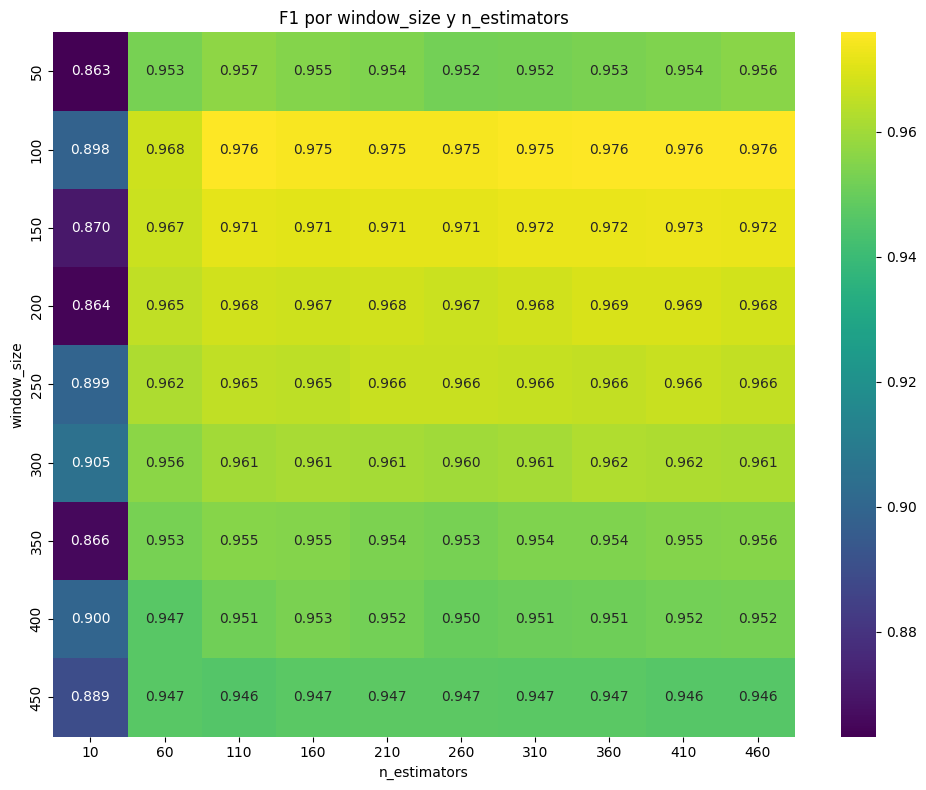

In [13]:

# Reorganizar datos a forma de tabla pivote
tabla = df_summary.pivot(index='window_size', columns='n_estimators', values='F1 Score')

# Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(tabla, annot=True, fmt=".3f", cmap='viridis')
plt.title("F1 por window_size y n_estimators")
plt.ylabel("window_size")
plt.xlabel("n_estimators")
plt.tight_layout()
plt.show()

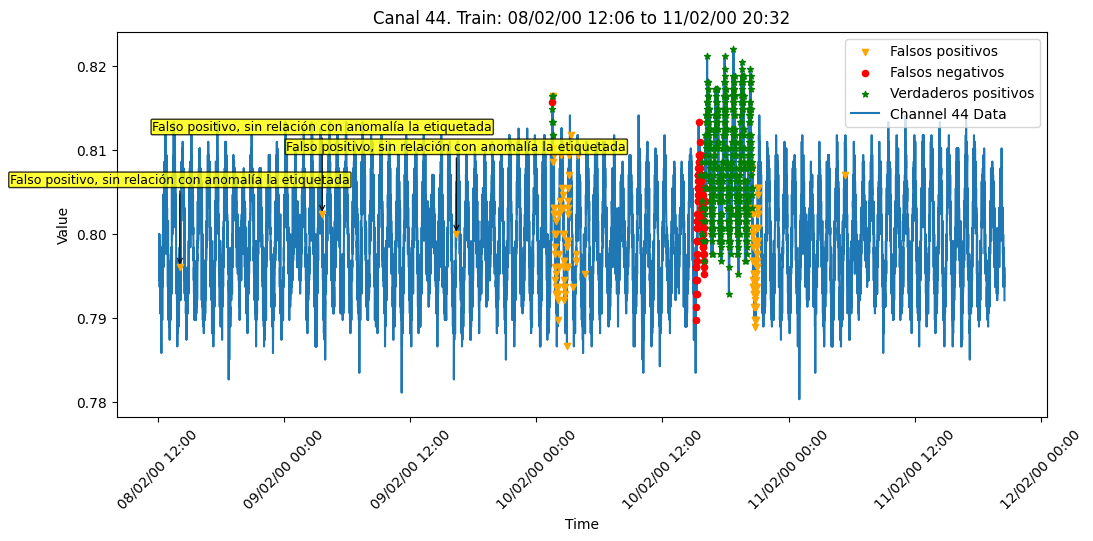

In [56]:
from matplotlib.patches import Rectangle

min_fecha = X_test.index.min()
max_fecha = X_test.index.max()
y_pred          = best_estimator.predict(best_estimator.X_test)
#y_pred_proba    = best_estimator.decision_function(best_estimator.X_test)
y_pred = y_pred < 0 # -0.07
df_subset.loc[best_estimator.X_test.index, ['y_pred']] = y_pred
X_test = df_subset[df_subset['y_pred'].isna()==False]

df_FN = X_test.loc[(X_test.isAnomaly==True) & (X_test.y_pred==False), tm.channel_name]
df_FP = X_test.loc[(X_test.isAnomaly==False) & (X_test.y_pred==True), tm.channel_name]
df_TP = X_test.loc[(X_test.isAnomaly==True) & (X_test.y_pred==True), tm.channel_name]

plt.figure(figsize=(12, 5))
plt.scatter(df_FP.index, df_FP, color='orange', label='Falsos positivos', s=20, marker="v", zorder=8)
plt.scatter(df_FN.index, df_FN, color='red', label='Falsos negativos', s=20, zorder=9)
plt.scatter(df_TP.index, df_TP, color='green', label='Verdaderos positivos', marker='*', s=20, zorder=10)

plt.plot(X_test.index, X_test[tm.channel_name], label='Channel 44 Data')


plt.title(f'Canal 44. Train: {min_fecha.strftime("%d/%m/%y %H:%M")} to {max_fecha.strftime("%d/%m/%y %H:%M")}')
plt.xlabel('Time')  
plt.ylabel('Value')
plt.xticks(rotation=45)
d_format = mdates.DateFormatter("%d/%m/%y %H:%M")  # Día-Mes-Año
# Aplicar el formato al eje x

ax = plt.gca()
ax.xaxis.set_major_formatter(d_format)

for i in range(3):
    x = df_FP.index[i]
    y = df_FP.iloc[i]


    ax.annotate(
        f'{"Falso positivo, sin relación con anomalía la etiquetada"}',
        xy=(x, y),
        xytext=(x, y+.01),
        ha='center',
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.1', fc='yellow', alpha=0.8),
        arrowprops=dict(arrowstyle='->', color='black', lw=0.8),
        zorder=12
    )

    

plt.legend()
plt.show()